In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import csv
import time as t

import joblib
import pickle

In [20]:
### File locations

In [5]:
file_path = "../Data_acquisition/Final DB/commercial/"
api_path = "../api/"

In [6]:
def plot_series(time, series, format="-", start = 0, end= None):
  '''
  Visualize the data
  '''
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
### Read input data

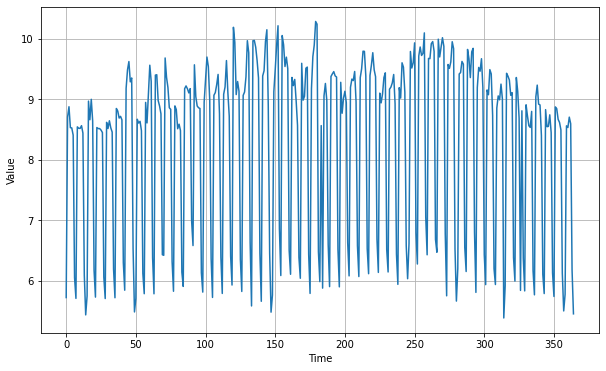

In [7]:
time_step = []
temps = []

with open(file_path + "merged_energy.csv") as csvfile:
  reader = csv.reader(csvfile,delimiter = ',')
  next(reader) #first line
  step = 0
  for row in reader:
    temps.append(float(row[3]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [ ]:
### Normalize data

In [19]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1))
series_scaled = series_scaled.flatten()

In [10]:
#Train test split 70:30
time_split = int(len(time_step)*0.7)
time_train = time[:time_split]
x_train = series_scaled[:time_split]
time_valid = time[time_split:]
x_valid = series_scaled[time_split:]

#Keep true x_valid for comparison
x_valid_true = series[time_split:]
shuffle_buffer_size = len(x_train)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''
    Create dataset follow the a certain window
    Ref: Course and Book2
    '''
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    '''
    Subfunction to forecast a single input point
    Ref: Course and Book2
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
### Create training model - One-layer LSTM

===================] - 0s 7ms/step - loss: 0.0163 - mae: 0.1278
Epoch 189/400
3/3 [==============================] - 0s 7ms/step - loss: 0.0164 - mae: 0.1318
Epoch 190/400
3/3 [==============================] - 0s 8ms/step - loss: 0.0161 - mae: 0.1288
Epoch 191/400
3/3 [==============================] - 0s 7ms/step - loss: 0.0160 - mae: 0.1284
Epoch 192/400
3/3 [==============================] - 0s 7ms/step - loss: 0.0160 - mae: 0.1293
Epoch 193/400
3/3 [==============================] - 0s 7ms/step - loss: 0.0160 - mae: 0.1273
Epoch 194/400
3/3 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.1287
Epoch 195/400
3/3 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.1300
Epoch 196/400
3/3 [==============================] - 0s 9ms/step - loss: 0.0158 - mae: 0.1264
Epoch 197/400
3/3 [==============================] - 0s 8ms/step - loss: 0.0159 - mae: 0.1270
Epoch 198/400
3/3 [==============================] - 0s 8ms/step - loss: 0.0164 - mae: 0.1

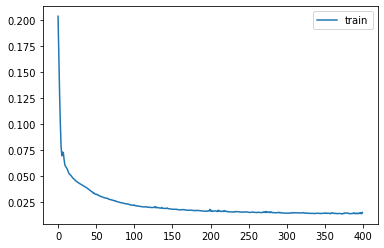

38.84229278564453


In [13]:
#LSTM 1 layer
start = t.time()
tf.random.set_seed(0)
np.random.seed(0)

window_size = 7
train_set = windowed_dataset(x_train, window_size = window_size, batch_size= 120, shuffle_buffer = shuffle_buffer_size)
model = Sequential([
    LSTM(64, return_sequences=True),
    Dense(64, activation="relu"), 
    Dense(32, activation="relu"),
    Dense(1)
])

optimizer = "adam"
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=400, verbose = 0)

print(t.time()-start)

In [ ]:
# Store the trained model

In [14]:
joblib.dump(scaler,api_path + "scaler.gz")

['../api/scaler.gz']

In [15]:
model.save(api_path + "model.hdf5")

In [ ]:
# Test forecasting

In [16]:
start = t.time()

results = model_forecast(model, series_scaled.reshape(-1,1), window_size)
results = results[time_split - window_size:-1, -1, 0]

print(t.time()-start)

0.5078837871551514


0.3386738718795112


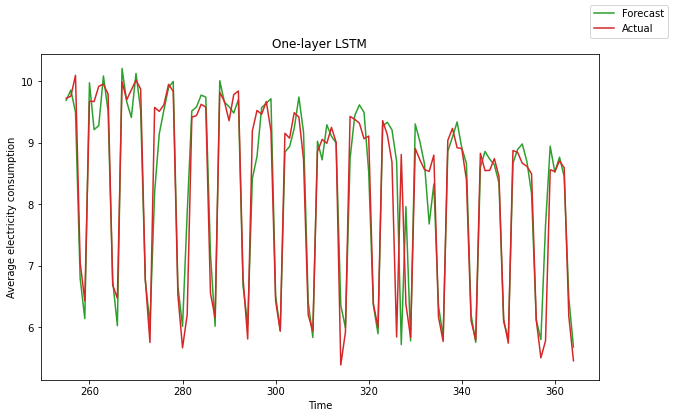

In [17]:
results = scaler.inverse_transform(results[np.newaxis]).reshape(-1,)

fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, results, color = "tab:green", label = "Forecast")
ax1.plot(time_valid, x_valid_true, color = "tab:red", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("One-layer LSTM")
ax1.set_ylabel("Average electricity consumption")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

#Calculate MAE
print(mean_absolute_error(results,x_valid_true))